[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nlcuccia/AM216/blob/master/HW1/P3.ipynb)

## Problem 3

In this problem, you will import images into Python and display them. You will also explore an important operation in image analysis: convolution. If you've ever played with photographic software such as GIMP (or a commercial alternative), you've probably used convolutions to smooth or sharpen images but perhaps you didn't know it. Your eyes and brain are also doing convolutions whenever you look at anything.

Not all visual data comes from photographs. Many kinds of experimental measurements generate arrays of numbers associated with points in space. Such data can be communicated to our brains as images, as in atomic force microscopy, computed tomography, and magnetic resonance imaging. Image processing is useful for making these images more meaningful to humans.

Our goals in this homework are to:
* Explore the effects of various kinds of local averaging on an image;
* See how to use such averaging to decrease noise in an image; and
* Use specialized methods to restore a convolved image.

### 1.0 Initialization

In [1]:
%matplotlib inline

import numpy as np 
from scipy.integrate import quad
from scipy.stats import chi2
from scipy.ndimage.interpolation import rotate
import scipy.integrate as integrate
import scipy.ndimage as sim
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

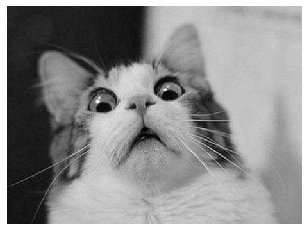

In [2]:
gauss_filter = np.load('gauss_filter.npy')
cat = plt.imread('cat.tiff')

plt.figure()
plt.imshow(cat)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

def cat_plotter(conv_kitty, 
            kitty = cat,
            labels = ["Original Gray Photo", "Convolutional Gray Photo","Difference Gray Photo",
                      "Original Gray Photo","Convolutional Jet Photo","Difference Jet Photo"],
            jet = True
           ):
    """
    Returns the a collection of figures showing differences before and after convolution
    
    Parameters
    ----------
    conv_kitty: ndarray
        the image which we have convolved and want to display
    kitty : ndarray
        the original image which we want to compare conv_kitty to
    labels : ndarray
        the titles with which we want to give our plots
    jet : boolean
        an option to give jet plots or not

    Returns
    -------
    """
    plt.figure(figsize=(10, 10))

    plt.subplot(4,3,1)
    plt.imshow(kitty)
    plt.title(labels[0])
    plt.axis('equal')
    plt.set_cmap('gray')
    plt.axis('off')

    plt.subplot(4,3,2)
    plt.imshow(conv_kitty)
    plt.title(labels[1])
    plt.axis('equal')
    plt.set_cmap('gray')
    plt.axis('off')
    
    plt.subplot(4,3,3)
    plt.imshow(conv_kitty-kitty)
    plt.title(labels[2])
    plt.axis('equal')
    plt.set_cmap('gray')
    plt.axis('off')
    
    if(jet == True):
        plt.subplot(4,3,4)
        plt.imshow(kitty)
        plt.title(labels[3])
        plt.axis('equal')
        plt.set_cmap('jet')
        plt.axis('off')

        plt.subplot(4,3,5)
        plt.imshow(conv_kitty)
        plt.title(labels[4])
        plt.axis('equal')
        plt.set_cmap('jet')
        plt.axis('off')
        
        plt.subplot(4,3,6)
        plt.imshow(conv_kitty-kitty)
        plt.title(labels[5])
        plt.axis('equal')
        plt.set_cmap('jet')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    return

### 1.1 Convolution

Python gives us access to tools for manipulating images, including convolutions. However, many of the details are hidden. Before getting into Python specifics, let's take a look at the mathematical definition and properties of convolution. A convolution is an operation we perform on probability distributions, but it has other uses as well. A common definition of the two-dimensional discrete convolution $C$ of an image array $I$ with a filter array $F$ is:

$$C_{i,j} = \sum_{k,l} F_{k,l} \,I_{i-k,j-l}$$ 

The sum ranges over all values of $k$ and $l$ that refer to legal entries of both $F$ and $I$. For example, we cannot have $i = 1$ and $k = 10$ because the first index of $I$ would be $−9$. (Python may accept this, but the result would not be what you intended.)

1. Consider the trivial transformation, for which $F$ is a $1 \times 1$ matrix with a single entry equal to $1$. Explain why $C$ is the same as $I$ in this case.
---
__Solution:__ When $F$ is a $1 \times 1$ matrix with the value of one, then the effect of the sum $\sum_{k,l} F_{k,l} \,I_{i-k,j-l}$ is to multiply each pixel in the image by one, thus returning an image $C$ that is equal to the origional image $I$.

---
2. Suppose that the size of $F$ is $m \times n$ , and that of $I$ is $M \times N$ . Explain why the size of $C$ is $(M + m - 1) \times (N + n - 1)$.
---
__Solution:__ As you drag the convolution accross the image vertically or horizontally, you will get values for each time the convoluiton function has its center within the image being convoluted (M or N), as well as each time the convolutoin touches the image but does not have its center in the image (m-1 or n-1). Thus, the final dimensions will be $(M + m - 1) \times (N + n - 1)$

---

When we convolve an image with a filter, we get another image. The expression in the above Equation is a set of instructions for constructing this new image: To create each pixel in $C$ , we take the pixels from a subset of the original image, multiply them by their respective weights in the filter, and add up the result. It's a simple recipe that can have very different results depending on the filter.

#### 1.1.1 Python Tools for Image Processing

Here we will utilize a module with several image processing functions:

`import scipy.ndimage as sim`

We chose the nickname sim as a mnemonic for "SciPy image library."

One useful function in this module is `sim.convolve`. Use `help` to learn about this function and its options. All of the filters we will use in this homework accept similar arguments.

In this homework, you will explore several filters and convolutions. As you proceed through the exercises, you will see a photograph transformed by each operation. To get an idea of what is happening on a pixel-by-pixel level, you can apply the same convolution to a single dot. (This is the __impulse response__ of the filter.) This will allow you to see the shape of the filter and better understand what you are doing to the photograph.

For example, if we have a single dot and a 3x3 uniform filter, we get the following result:

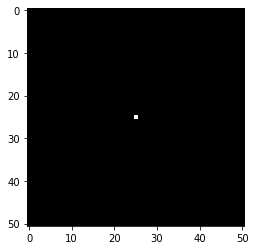

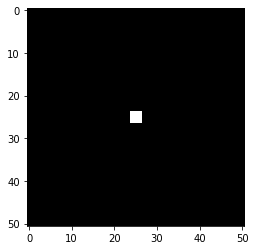

In [3]:
impulse = np.zeros( (51, 51) )
impulse[25, 25] = 1.0

plt.figure()
plt.imshow(impulse)
plt.show()

my_filter = np.ones( (3, 3) ) / 9
response = sim.convolve(impulse, my_filter)
plt.figure()
plt.imshow(response)
plt.show()

Compare the size of two arrays, `impulse` and `response`. They are the same! Generally, the convolution of an image with a filter is at least as large as the original image, and usually larger. Where do the extra points go in Python? Where did they come from in the mathematical derivation?  Let's find out!

Refer back to the above Equation and look at $C[0,0]$ . The allowed values of $k$ and $l$ for this point give only one contribution. Likewise, $C[M+m-2,N+n-2]$ has only one contribution:

$$C[0, 0] \text{   is   } F[0, 0]\,*\,I[0, 0]$$
$$C[M+m-2, N+n-2] \text{   is   } F[m-1, n-1] \,*\,I[M-1, N-1] $$

The points at the edges of the convolved image receive contributions from fewer points in the original image than do the points in the interior. This may lead to distortions at the edges of the convolved image. Python crops the edges and returns the central portion of the convolved image. This has two advantages. First, every point in the convolved image uses at least a quarter of the filter. Second, convolution does not change the size or aspect ratio of the original image.

The question remains of how to properly treat points at the edge of the convolution. The function `sim.convolve` and its relatives offer several options. The simplest is to imagine that the image is surrounded by an infinite black border. That means we (hypothetically) enlarge our image array to whatever size it needs to be to provide the proper number of points for every pixel in the convolution and set the values of all the new points to $0$. To select this behavior, use the keyword and value `mode='constant'` when calling `sim.convolve`. This overrides the default behavior, which is to pretend that the image is surrounded by reflections of itself.

#### 1.1.2 Averaging

A very simple filter assigns the same weight to each pixel in a fixed region, as in the impulse response example above. Each pixel in the convolved image is an average of its neighbors in the original image.

1. We will make a $3 \times 3$ array `my_filter` in which each element equals $1 / 9$. We'll call this array the "small square filter." Then we will convolve this filter with the original image using `sim.convolve()`.  Why does it make sense to choose the value $1/9$? 

__Solution:__ $1/9$ makes sense because it will assign each pixel in the filter weight according to its total portion of the filter area (1 pixel over the total area of pixels $3\times3=9$, thus $1/9$).


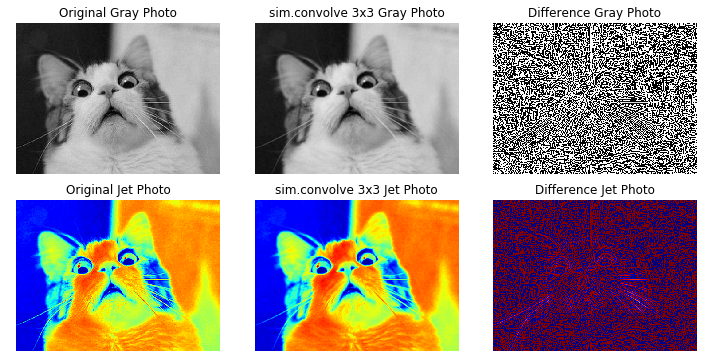

In [4]:
#Same as above, but using uniform_filter
cat = plt.imread('cat.tiff')
my_filter = np.ones((3,3))*(1/9)

######3x3######
response = sim.convolve(cat, my_filter)
lbl = ["Original Gray Photo", 
                      "sim.convolve 3x3 Gray Photo",
                       "Difference Gray Photo",
                      "Original Jet Photo",
                      "sim.convolve 3x3 Jet Photo",
                      "Difference Jet Photo"]
cat_plotter(response, cat, lbl)


2. Note that most packages don't require you to define your own filters.  They, in fact, have their own built-in filters.  For example, the 3x3 filter we made before can also be made using `sim.uniform_filter`.

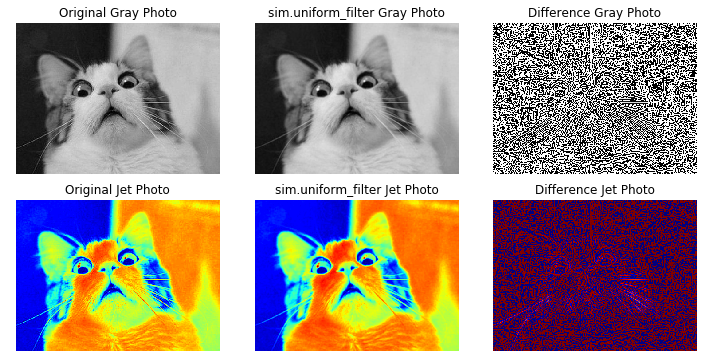

In [5]:
######Uniform 3x3######
response = sim.uniform_filter(cat,3)
lbl = ["Original Gray Photo", 
                      "sim.uniform_filter Gray Photo",
                       "Difference Gray Photo",
                      "Original Jet Photo",
                      "sim.uniform_filter Jet Photo",
                      "Difference Jet Photo"]
cat_plotter(response, cat, lbl)

3. Now we will repeat part (1) using a $15 \times 15$ array with an appropriate constant value for each element (the "large square filter"). Notice how the image changes with respect to the smaller filter.

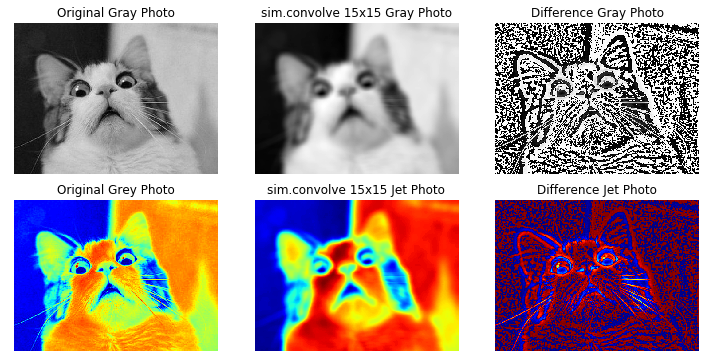

In [6]:
cat = plt.imread('cat.tiff')
my_filter = np.ones((15,15))/(15**2)

######15x15######
response = sim.convolve(cat, my_filter)
lbl = ["Original Gray Photo", 
                      "sim.convolve 15x15 Gray Photo",
                       "Difference Gray Photo",
                      "Original Grey Photo",
                      "sim.convolve 15x15 Jet Photo",
                      "Difference Jet Photo",]
cat_plotter(response, cat, lbl)

4. Use the definition in the above Equation to show that these convolutions produce images in which each pixel is the average of some of the neighboring pixels in the original.


__Solution:__ Each new pixel is an average of the surrounding pixels in the original image because the each pixel in the origional image is multiplied by $1/m$ and the new pixel is the sum of all of these terms. If you factor out the $1/n$, then you can see that this is the equation of an average.



#### 1.1.3 Smoothing with a Gaussian

Now we will look at a slightly more complex filter, called a Gaussian filter. We will load the file `gauss_filter.npy` into a NumPy array called `gauss`. You may wish to refresh your memory on the function `plot_surface`. 

1. We will display the convolution of `gauss` with the original image. (Note that the built in function `sim.gaussian_filter` has keyword options, so you can specify features such as `sigma = 5`.)

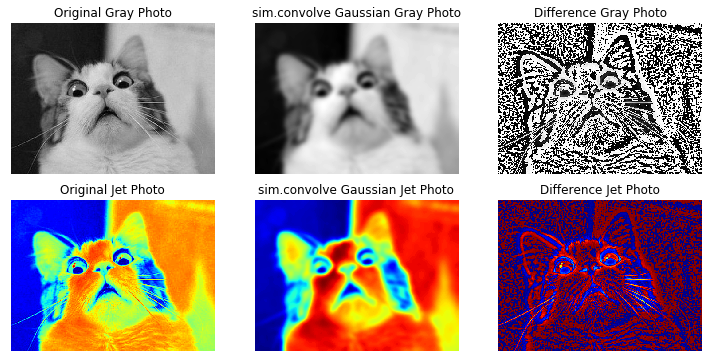

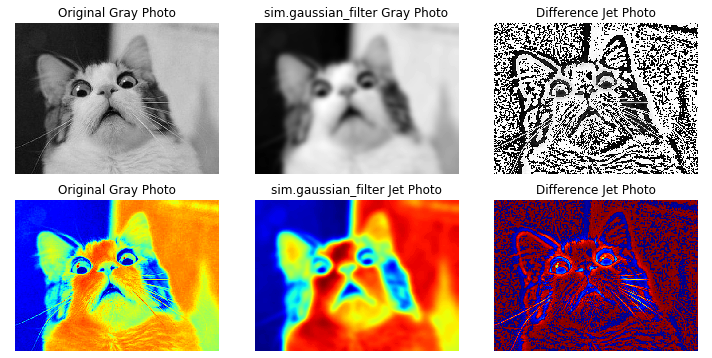

In [7]:
gauss = np.load('gauss_filter.npy')
response = sim.convolve(cat, gauss)

######Gaussian that we define######
lbl = ["Original Gray Photo", 
                      "sim.convolve Gaussian Gray Photo",
                       "Difference Gray Photo",
                      "Original Jet Photo",
                      "sim.convolve Gaussian Jet Photo",
                      "Difference Jet Photo"]
cat_plotter(response, cat, lbl)

######Gaussian from built in package######
response = sim.gaussian_filter(cat, sigma = 5)
lbl = ["Original Gray Photo", 
                      "sim.gaussian_filter Gray Photo",
                       "Difference Jet Photo",
                      "Original Gray Photo",
                      "sim.gaussian_filter Jet Photo",
                      "Difference Jet Photo"]
cat_plotter(response, cat, lbl)

2. Now we will use `plt.imshow` to compare the convolutions of a single dot with a Gaussian filter and the square filter we used before.

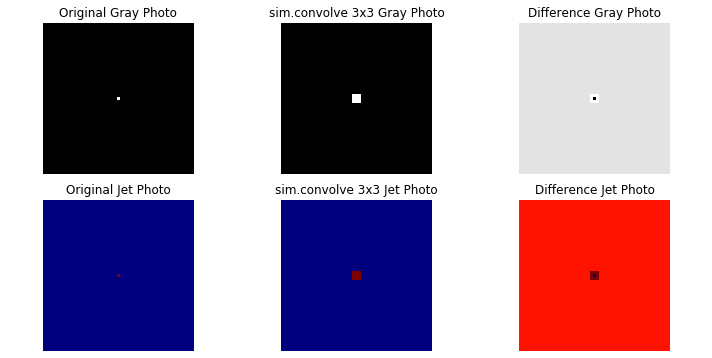

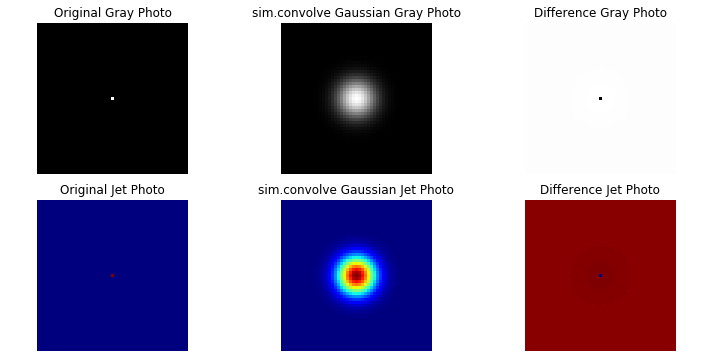

In [8]:
impulse = np.zeros( (51, 51) )
impulse[25, 25] = 1.0
my_filter = np.ones( (3, 3) ) / 9

######3x3######
response = sim.convolve(impulse, my_filter)
lbl = ["Original Gray Photo", 
                      "sim.convolve 3x3 Gray Photo",
                       "Difference Gray Photo",
                      "Original Jet Photo",
                      "sim.convolve 3x3 Jet Photo",
                      "Difference Jet Photo"]
cat_plotter(response, impulse, lbl)

######Gaussian######
gauss = np.load('gauss_filter.npy')
response = sim.convolve(impulse, gauss)

lbl = ["Original Gray Photo", 
                      "sim.convolve Gaussian Gray Photo",
                      "Difference Gray Photo",
                      "Original Jet Photo",
                      "sim.convolve Gaussian Jet Photo",
                      "Difference Jet Photo"]
cat_plotter(response, impulse, lbl)

3. Using `plot_surface` we can view the convolved images from part (2) in three dimensions. This is actually a plot of the filters themselves. Use the definition of convolution to explain why. Then, explain how convolution with a Gaussian filter differs from a square filter, and under what circumstances one might prefer a Gaussian filter.

__Solution: [TYPE SOLUTION HERE]__

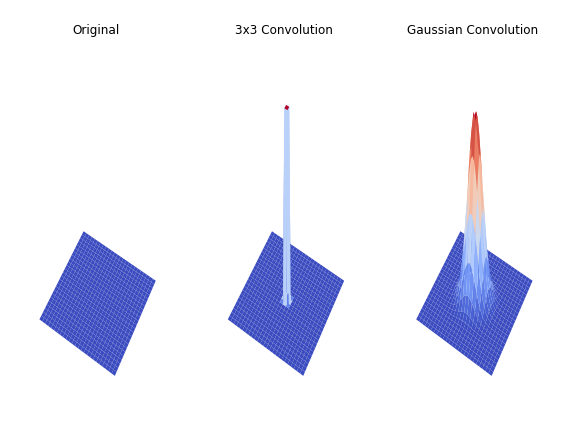

In [9]:
x = np.arange(0, 51, 1)
y = np.arange(0, 51, 1)
xx, yy = np.meshgrid(x, y, sparse=True) #Grid for our 3-D Plot

impulse = np.zeros((51, 51))
impulse[25, 25] = 1

fig = plt.figure(figsize=(8, 6))

#######Original Cat#######
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(xx,yy,impulse,cmap=cm.coolwarm)
plt.axis('off')
# plt.axis('equal')
plt.title("Original")

#######3x3#######
my_filter = np.ones((3,3)) / 9
response = sim.convolve(impulse, my_filter)

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(xx,yy,response,cmap=cm.coolwarm)
plt.axis('off')
# plt.axis('equal')
plt.title("3x3 Convolution")

#######Gaussian#######
gauss = np.load('gauss_filter.npy')
response = sim.convolve(impulse, gauss)

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(xx,yy,response,cmap=cm.coolwarm)
plt.axis('off')
# plt.axis('equal')
plt.title("Gaussian Convolution")

plt.tight_layout()
plt.show()

### 1.2 Deconvolution

Now, we are going to examine an existing method for restoring images.  Generally, these methods are known as deconvolution.  You should examine the different methods in `skimage` for deconvolving images.  Some methods are often better than others under certain circumstances.  Note that the functions in `skimage` refer to the __impulse response__ at the __point spread function (PSF)__.  These two terms are often used interchangeably.  

When using these methods for deconvolution, they generally require you to provide a guess at what the manipulation to the data was.  Otherwise, the methods will have a lot of difficulty converging to a good image.  Typically, as is often true with data-driven methods, we simply have to make guesses at which options and filters will produce the best results.  When we examine machine learning later in the course, we will see how much guess-and-checking is often required to solve these kinds of problems.

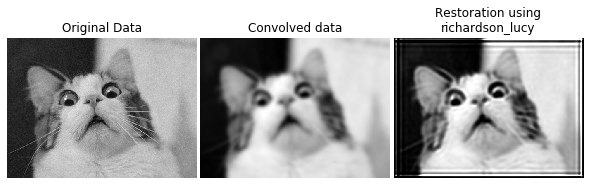

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import restoration

#Scipy's methods requires pixel values between 0 and 1
cat = plt.imread('cat.tiff')/255

# (OPTIONAL) Add Noise to Image
cat += (np.random.poisson(lam=25, size=cat.shape) - 10) / 255.

cat_convolve = sim.gaussian_filter(cat, sigma = 4)

#We want to create a Point Spread Function which we input into the restoration function.
#We do this by creating an impulse response
point = np.zeros(cat.shape)
point[cat.shape[0]//2, cat.shape[1]//2] = 1 #Single point at the center
psf = sim.gaussian_filter(point, sigma = 4)

# Restore Image using Richardson-Lucy algorithm for a Gaussian Filter
deconvolved_RL = restoration.richardson_lucy(cat_convolve, psf, iterations=50)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(cat)
ax[0].set_title('Original Data')

ax[1].imshow(cat_convolve)
ax[1].set_title('Convolved data')

ax[2].imshow(deconvolved_RL, vmin=cat_convolve.min(), vmax=cat_convolve.max())
ax[2].set_title('Restoration using\nrichardson_lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

10332.188579065618

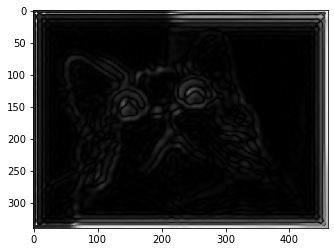

In [11]:
plt.imshow(np.abs(cat_convolve-deconvolved_RL))
np.sum(np.sqrt((cat-deconvolved_RL)**2))

### 1.3 DIY

Now, you should play more with the different deconvolution methods which exist in python's vast library of packages. The final problem of this homework will be to try and deconvolve an image without knowledge of the image's _point spread function_.  This is a quintessential inverse-problem.  We want to try and determine the original data and the manipulation done to the data while only knowing the final (often noisy) form of the data.  

We are providing you a new image (`Michael_P3.npy`) which has been manipulated.  We have added _noise_ and we have _convolved_ the image.  Your job is to try and restore the image as best as possible.  Your final guess for the pixel values should be uploaded to the Kaggle for the course.

In [12]:
michael = np.load('Michael_P3.npy')

Min: 0.08481400676268591
Max: 0.9706119969275664
Mean: 0.4514682941960786
Var: 0.035423757156107905


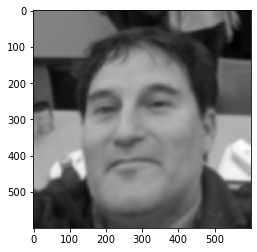

In [13]:
def summary_stats(image):
    """Prints a few summary statistics of an image"""
    print("Min: "+str(np.min(image)))
    print("Max: "+str(np.max(image)))
    print("Mean: "+str(np.mean(image)))
    print("Var: "+str(np.var(image)))
    
    return None

def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

summary_stats(michael)
plot = plt.imshow(michael)

Ok so looking at the image one thing I notice right of the bat is the the $100\times100$ pixel area in the top left seems to have been a relatively uniform shade in the origional picture. Let's look more closely. 

Min: 0.5289231442937503
Max: 0.5417892644473659
Mean: 0.5351413925899072
Var: 7.817715679961488e-06


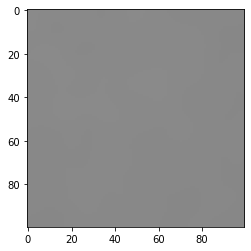

In [14]:
summary_stats(michael[0:100,0:100])
plot = plt.imshow(michael[0:100,0:100], vmin=0, vmax=1)

Ok so looking at the top right corner and its summary statistics, we can see that it is basically uniformly grey with a super small variance. This means that either the noise added to the image was very small, or that the convolution was very strong and smoothed it away (or both). 

In [15]:
# Create a point to build the filters
point = np.zeros(point.shape)
point[point.shape[0]//2, point.shape[1]//2] = 1

# Make several gaussian filters with different sigmas
psf_sig1 = sim.gaussian_filter(point, sigma = 1)
psf_sig2 = sim.gaussian_filter(point, sigma = 2)
psf_sig4 = sim.gaussian_filter(point, sigma = 4)
psf_sig4_1 = sim.gaussian_filter(point, sigma = 4.1)
psf_sig6 = sim.gaussian_filter(point, sigma = 6)

In [16]:
# Create restorations using richardson_lucy
RL_sig2 = restoration.richardson_lucy(michael, psf_sig2)
RL_sig4 = restoration.richardson_lucy(michael, psf_sig4)
RL_sig6 = restoration.richardson_lucy(michael, psf_sig6)

# Create restorations using unsupervised_wiener
UW_sig2,_ = restoration.unsupervised_wiener(michael, psf_sig2)
UW_sig4,_ = restoration.unsupervised_wiener(michael, psf_sig4)
UW_sig6,_ = restoration.unsupervised_wiener(michael, psf_sig6)

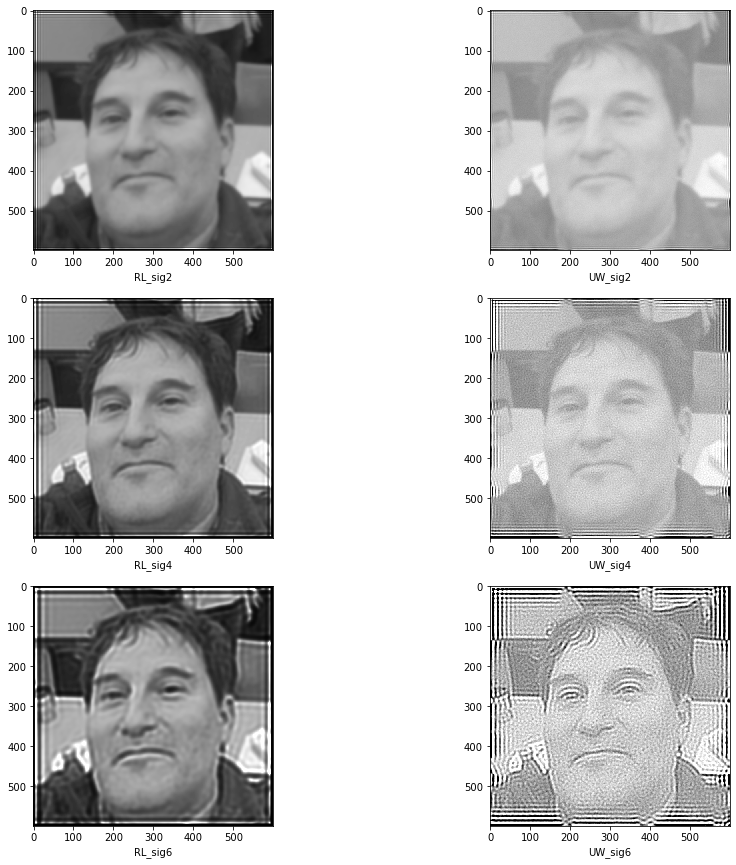

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
axs[0,0].imshow(RL_sig2)
axs[0,0].set_xlabel("RL_sig2")
axs[1,0].imshow(RL_sig4)
axs[1,0].set_xlabel("RL_sig4")
axs[2,0].imshow(RL_sig6)
axs[2,0].set_xlabel("RL_sig6")
axs[0,1].imshow(UW_sig2)
axs[0,1].set_xlabel("UW_sig2")
axs[1,1].imshow(UW_sig4)
axs[1,1].set_xlabel("UW_sig4")
axs[2,1].imshow(UW_sig6)
axs[2,1].set_xlabel("UW_sig6")
plt.show()

Looking at the results, it looks like richardson-lucy with a sigma of 4 did the best. Now let's look at the images themselves as well as their summary statistics side by side.

Original Stats:
Min: 0.08481400676268591
Max: 0.9706119969275664
Mean: 0.4514682941960786
Var: 0.035423757156107905

New Stats:
Min: 7.874320286351368e-14
Max: 1.0
Mean: 0.44688583828794265
Var: 0.04442604565763585


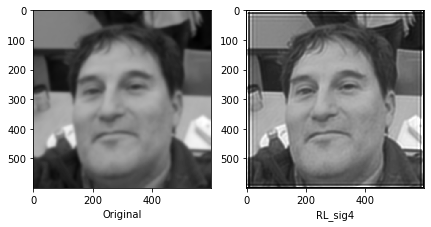

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(7,7))
axs[0].imshow(michael)
axs[0].set_xlabel("Original")
axs[1].imshow(RL_sig4)
axs[1].set_xlabel("RL_sig4")
print("Original Stats:")
summary_stats(michael)
print("\nNew Stats:")
summary_stats(RL_sig4)

Looking at a lot of the finer features, we have clearly recovered lots of the details that were lost in the noise/convolution. However, we have some artifacts on the edges. So let's try embedding the image in a backgound of the mean value of the overall image before we perform the deconvolution. 

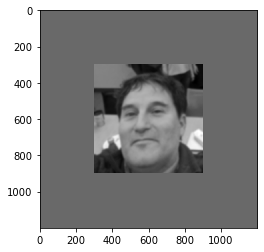

In [19]:
img_dims = michael.shape

embedded_michael = np.ones((2*img_dims[0],2*img_dims[1]))
embedded_michael = embedded_michael*np.mean(michael)
embedded_michael[img_dims[0]//2:img_dims[0]//2+img_dims[0], img_dims[1]//2:img_dims[1]//2+img_dims[1]]=michael
plot = plt.imshow(embedded_michael)

In [20]:
RL_sig4_embedded = restoration.richardson_lucy(embedded_michael, psf_sig4)
RL_sig4_embedded = RL_sig4_embedded[img_dims[0]//2:img_dims[0]//2+img_dims[0], img_dims[1]//2:img_dims[1]//2+img_dims[1]]

Original Stats:
Min: 0.08481400676268591
Max: 0.9706119969275664
Mean: 0.4514682941960786
Var: 0.035423757156107905

RL_sig4 Stats:
Min: 7.874320286351368e-14
Max: 1.0
Mean: 0.44688583828794265
Var: 0.04442604565763585

RL_sig4_embedded Stats:
Min: 0.00432179922662255
Max: 1.0
Mean: 0.45053312109169596
Var: 0.038541731830965875


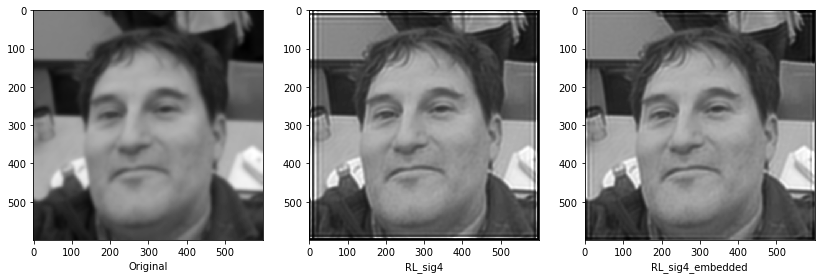

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(14,14))
axs[0].imshow(michael)
axs[0].set_xlabel("Original")
axs[1].imshow(RL_sig4)
axs[1].set_xlabel("RL_sig4")
axs[2].imshow(RL_sig4_embedded)
axs[2].set_xlabel("RL_sig4_embedded")
print("Original Stats:")
summary_stats(michael)
print("\nRL_sig4 Stats:")
summary_stats(RL_sig4)
print("\nRL_sig4_embedded Stats:")
summary_stats(RL_sig4_embedded)

Ok so the embedding trick definetly worked, however we still have these kind of line artifacts. I think this is being caused by the sudden transition from grey to the image, which creates an artifical edge. Maybe we can alleviate this even more by embedding the image in a reflection of itself. Let's try that below. 

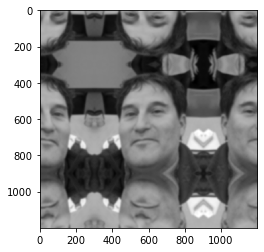

In [22]:
michael_vflip = np.flip(michael,axis=0)
michael_hflip = np.flip(michael,axis=1)
michael_bflip = np.flip(michael_vflip, axis=1)
embedded_michael_2 = embedded_michael

# Add vertical componenets
embedded_michael_2[0:img_dims[0]//2,
                 img_dims[1]//2:img_dims[1]//2+img_dims[1]] = michael_vflip[img_dims[0]//2:,:]

embedded_michael_2[img_dims[0]+img_dims[0]//2:,
                 img_dims[1]//2:img_dims[1]//2+img_dims[1]] = michael_vflip[0:img_dims[0]//2,:]

# Add horizontal components
embedded_michael_2[img_dims[0]//2:img_dims[0]//2+img_dims[0],
                 0:img_dims[1]//2] = michael_hflip[:,img_dims[1]//2:None]

embedded_michael_2[img_dims[0]//2:img_dims[0]//2+img_dims[0],
                 img_dims[1]+img_dims[1]//2:] = michael_hflip[:,0:img_dims[1]//2]

# Add the corners
embedded_michael_2[0:img_dims[0]//2,
                 0:img_dims[1]//2] = michael_bflip[img_dims[0]//2:None,img_dims[1]//2:None]

embedded_michael_2[0:img_dims[0]//2,
                 img_dims[1]+img_dims[1]//2:None] = michael_bflip[img_dims[0]//2:None,0:img_dims[1]//2]

embedded_michael_2[img_dims[0]+img_dims[0]//2:None,
                 0:img_dims[1]//2] = michael_bflip[0:img_dims[0]//2,img_dims[1]//2:None]

embedded_michael_2[img_dims[0]+img_dims[0]//2:None,
                 img_dims[1]+img_dims[1]//2:None] = michael_bflip[0:img_dims[0]//2,0:img_dims[1]//2]

plt.imshow(embedded_michael_2)

In [23]:
RL_sig4_embedded_2 = restoration.richardson_lucy(embedded_michael_2, psf_sig4, iterations=200)
test_img = RL_sig4_embedded_2[img_dims[0]//2:img_dims[0]//2+img_dims[0], img_dims[1]//2:img_dims[1]//2+img_dims[1]]

Original Stats:
Min: 0.08481400676268591
Max: 0.9706119969275664
Mean: 0.4514682941960786
Var: 0.035423757156107905

RL_sig4_embedded Stats:
Min: 7.874320286351368e-14
Max: 1.0
Mean: 0.44688583828794265
Var: 0.04442604565763585

RL_sig4_embedded_2 Stats:
Min: 1.2393008982546426e-52
Max: 1.0
Mean: 0.4414255167196063
Var: 0.045058560454150444


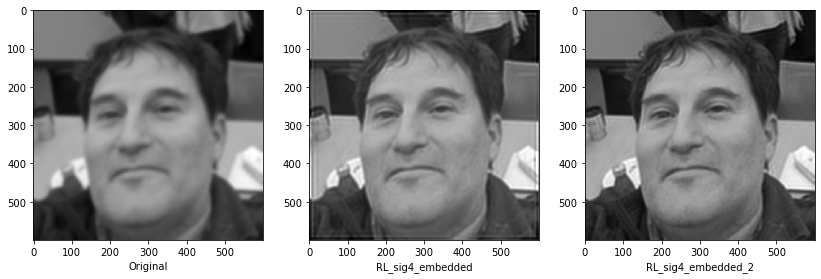

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(14,14))
axs[0].imshow(michael)
axs[0].set_xlabel("Original")
axs[1].imshow(RL_sig4_embedded)
axs[1].set_xlabel("RL_sig4_embedded")
axs[2].imshow(RL_sig4_embedded_2[img_dims[0]//2:img_dims[0]//2+img_dims[0], img_dims[1]//2:img_dims[1]//2+img_dims[1]])
axs[2].set_xlabel("RL_sig4_embedded_2")
print("Original Stats:")
summary_stats(michael)
print("\nRL_sig4_embedded Stats:")
summary_stats(RL_sig4)
print("\nRL_sig4_embedded_2 Stats:")
summary_stats(RL_sig4_embedded_2)

Now we can see that we have gotten rid of the artifacts almost entirely. Still, the image looks a bit blurry. ALso, the mean for this image is similar to the original, but many convolutions actually raise the mean value of the convoluted image. So we want to sharpen the image in a way that will also lower its mean slightly. Looking around online, there are many convolutions that sharpen edges. These are often used to pre-proccess images before they are fed to neural nets and such. Let's try using on of these filters and see if we can sharpen the image and lower its mean.


RL_sig4_embedded_2 Stats:
Min: 0.06354044655148147
Max: 0.9959149231219173
Mean: 0.4512053907525843
Var: 0.037592271384953996

Sharpened Stats:
Min: 0.0
Max: 1.0
Mean: 0.414153667044701
Var: 0.04200036544335977


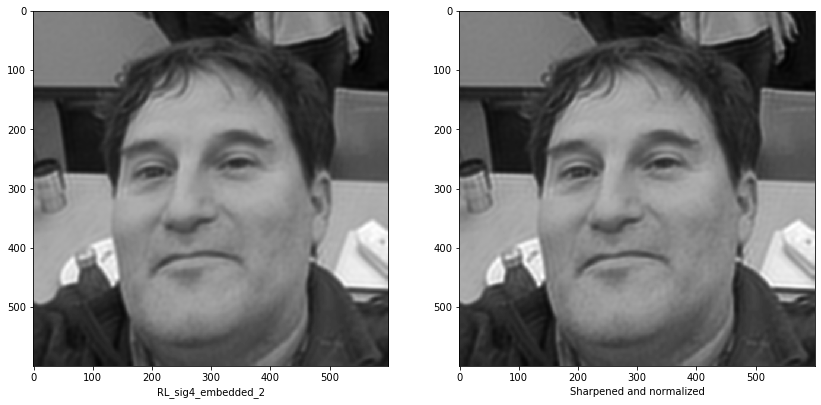

In [27]:
sharpen_filter = np.ones((3,3))*-1
sharpen_filter[1,1] = 11
test_img_2 = normalize_image(sim.convolve(test_img, sharpen_filter))

fig, axs = plt.subplots(1, 2, figsize=(14,14))
axs[0].imshow(test_img)
axs[0].set_xlabel("RL_sig4_embedded_2")
axs[1].imshow(test_img_2)
axs[1].set_xlabel("Sharpened and normalized")

print("\nRL_sig4_embedded_2 Stats:")
summary_stats(test_img)
print("\nSharpened Stats:")
summary_stats(test_img_2)

This convolution did sharpen the images (very slightly, look around the eye and the hand in the background), but also lowered the mean. I also tried applying a few different denoising methods, but they all seemed to actually degredate the image quality. But actually, it seems to me that the major difference was in the lowered mean and not the sharpening itself. Looking back at the stats for the original image, the lowest value is ~0.08. However, I would be willing to bet that in the actual orinal image, the lowest value was almost 0 since there is white in the photo. Therefore, I will submit a picture of the unsharpened michael with the minimum value subtracted so that the new minimum value is 0.

In [46]:
test_img_3 = test_img-np.min(test_img)

To help submit your file to Kaggle, we provide code here which will put your array into the correct file format.  This code will flatten your 2D array into a 1D array, and put it into an integer form with values between 0 and 255.  It will then append the index for each value and export the final array as a CSV file.  To submit your file go to [this Kaggle competition](https://www.kaggle.com/t/4c67618ec03740b09405aba2700e7bb1)

In [47]:
final = test_img_3
flat = np.round(final.flatten() * 255) #Flatten and rescale the values
num = np.arange(len(flat)) + 1 
kaggle = np.vstack((num, flat)).astype(int).T
np.savetxt('Miller_Zachary_kaggle.csv', kaggle, fmt='%i', delimiter=",", header = 'Id,Predicted', comments='')